# Explanation analysis for the neural network model
In this notebook is performed an explanation analysis for the neural network model, using two approaches: SHAP and LIME.

In [1]:
import shap
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
import lime
from tqdm import tqdm
from aix360.metrics import faithfulness_metric, monotonicity_metric
from xai_utils import *

/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [2]:
data = pd.read_csv("../dataset/cleaned_user_profiles.csv", index_col=0)

In [3]:
data.head()

name lang  bot           created_at  statuses_count  \
2353593986   Lamonica Raborn   en    1  2019-02-22 18:00:42              76   
2358850842     Lourie Botton   en    0  2019-02-26 03:02:32              54   
137959629   Dadan Syarifudin   en    1  2015-04-30 07:09:56              53   
466124818     Carletto Focia   it    1  2017-01-18 02:49:18              50   
2571493866         MBK Ebook   en    0  2019-06-18 19:30:21            7085   

            avg_length  avg_special_chars  urls_ratio  mentions_ratio  \
2353593986   62.340909          14.015152    0.000000        0.272727   
2358850842   69.082645          15.041322    0.000000        0.338843   
137959629    65.340909          14.694444    0.000000        0.000000   
466124818    86.944871          18.689463    0.022331        0.006281   
2571493866   72.311246          14.582073    0.000825        0.506461   

            hashtags_ratio  reply_count_mean  reply_count_std  \
2353593986        0.098485               0.0              0.0   
2358850842        0.024793               0.0              0.0   
137959629         0.000000               0.0              0.0   
466124818         0.072575               0.0              0.0   
2571493866        0.118229               0.0              0.0   

            favorite_count_mean  favorite_count_std  favorite_count_entropy  \
2353593986             0.037879            0.190903                0.232481   
2358850842             0.049587            0.217090                0.284639   
137959629              0.000000            0.000000                0.000000   
466124818              0.165387            0.530838                0.669155   
2571493866             0.056365            0.243387                0.317182   

            retweet_count_mean  retweet_count_std  retweet_count_entropy  
2353593986            0.037879           0.190903               0.232481  
2358850842            0.024793           0.155495               0.167568  
137959629             0.000000           0.000000              -0.000000  
466124818             0.826239          13.034008               0.392850  
2571493866            0.016772           0.142619               0.120737

In [4]:
# A description of the dataset
data.describe()

bot  statuses_count    avg_length  avg_special_chars  \
count  11508.000000    11508.000000  11508.000000       11508.000000   
mean       0.531456     5148.794751     67.100135          15.045892   
std        0.499031    18496.606420     12.755296           2.454106   
min        0.000000        0.000000     32.500000           9.644166   
25%        0.000000       53.000000     59.686796          13.553296   
50%        1.000000       57.000000     65.340909          14.694444   
75%        1.000000     2041.000000     74.254999          16.772205   
max        1.000000   399555.000000    104.449541          22.000000   

         urls_ratio  mentions_ratio  hashtags_ratio  reply_count_mean  \
count  11508.000000    11508.000000    11508.000000      11508.000000   
mean       0.031045        0.347537        0.101921          0.001967   
std        0.053379        0.343735        0.093837          0.007796   
min        0.000000        0.000000        0.000000          0.000000   
25%        0.000000        0.010260        0.045455          0.000000   
50%        0.005109        0.303797        0.073394          0.000000   
75%        0.037445        0.500000        0.128810          0.000000   
max        0.287760        1.726592        0.478261          0.044444   

       reply_count_std  favorite_count_mean  favorite_count_std  \
count     11508.000000         11508.000000        11508.000000   
mean          0.023941             0.084282            0.365569   
std           0.068508             0.109623            0.408441   
min           0.000000             0.000000            0.000000   
25%           0.000000             0.017751            0.136692   
50%           0.000000             0.045752            0.230747   
75%           0.000000             0.088862            0.451218   
max           0.333767             0.529903            2.183383   

       favorite_count_entropy  retweet_count_mean  retweet_count_std  \
count            11508.000000        11508.000000       11508.000000   
mean                 0.385430           98.347409         361.956697   
std                  0.390787          329.248000         626.207734   
min                  0.000000            0.000000           0.000000   
25%                  0.119116            0.022901           0.151796   
50%                  0.268594            0.096931           0.437106   
75%                  0.491767           74.499524         533.013057   
max                  1.723913        14432.000000        5442.443396   

       retweet_count_entropy  
count           11508.000000  
mean                1.011612  
std                 1.412183  
min                -0.000000  
25%                 0.136059  
50%                 0.312150  
75%                 1.462435  
max                 9.161105

In [5]:
train_set, test_set, train_label, test_label = prepare_data(data)

Features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std', 'retweet_count_entropy']


In [6]:
features = test_set.columns.to_list() # Creates a list with the name of all the features

In [7]:
scaler = StandardScaler()

# Applies standard scaler trasformation
train_X = scaler.fit_transform(train_set)
test_X = scaler.transform(test_set)

## Model loading
Here we load the neural network model

In [8]:
with open("../models_checkpoints/nn_no_lang.bin", "rb") as f:
    nn_model = pickle.load(f)

Trying to unpickle estimator LabelBinarizer from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator MLPClassifier from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [9]:
nn_model

MLPClassifier(hidden_layer_sizes=[16, 8], learning_rate_init=0.01, max_iter=100,
              momentum=0.1, random_state=8)

## Explain model

### SHAP

In [10]:
shap.initjs()

#### Global explanation

In [11]:
explainer = shap.KernelExplainer(nn_model.predict_proba, shap.sample(train_X, 20))

In [12]:
shap_values = explainer.shap_values(test_X[0:200])

  0%|                                                                                                                                                                               | 0/200 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

  3%|█████                                                                                                                                                                  | 6/200 [00:01<00:35,  5.39it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

  6%|█████████▉                                                                                                                                                            | 12/200 [00:02<00:36,  5.17it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

  9%|██████████████▉                                                                                                                                                       | 18/200 [00:03<00:35,  5.10it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 12%|███████████████████▉                                                                                                                                                  | 24/200 [00:04<00:32,  5.44it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 15%|████████████████████████▉                                                                                                                                             | 30/200 [00:05<00:31,  5.33it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 18%|█████████████████████████████▉                                                                                                                                        | 36/200 [00:06<00:31,  5.27it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 21%|██████████████████████████████████▊                                                                                                                                   | 42/200 [00:07<00:28,  5.55it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 24%|███████████████████████████████████████▊                                                                                                                              | 48/200 [00:09<00:27,  5.46it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 27%|████████████████████████████████████████████▊                                                                                                                         | 54/200 [00:10<00:27,  5.32it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 30%|█████████████████████████████████████████████████▊                                                                                                                    | 60/200 [00:11<00:26,  5.30it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 33%|██████████████████████████████████████████████████████▊                                                                                                               | 66/200 [00:12<00:25,  5.32it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 72/200 [00:13<00:23,  5.39it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 78/200 [00:14<00:23,  5.26it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 84/200 [00:15<00:21,  5.36it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 90/200 [00:16<00:19,  5.54it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 96/200 [00:18<00:18,  5.49it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 102/200 [00:19<00:18,  5.40it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                            | 108/200 [00:20<00:17,  5.31it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 114/200 [00:21<00:16,  5.20it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 120/200 [00:22<00:16,  4.98it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 126/200 [00:23<00:16,  4.58it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 132/200 [00:25<00:13,  5.06it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 138/200 [00:26<00:12,  5.09it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 144/200 [00:27<00:11,  5.01it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 150/200 [00:28<00:10,  4.99it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 156/200 [00:29<00:08,  4.93it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 162/200 [00:31<00:08,  4.72it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 168/200 [00:32<00:06,  4.72it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 174/200 [00:33<00:05,  4.95it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 180/200 [00:34<00:03,  5.09it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 186/200 [00:36<00:02,  4.88it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 192/200 [00:37<00:01,  4.76it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 198/200 [00:38<00:00,  4.79it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

In [13]:
shap.force_plot(explainer.expected_value[0], shap_values[0], test_X, link="logit",feature_names=features)

In [14]:
shap.force_plot(explainer.expected_value[1], shap_values[1], test_X, link="logit",feature_names=features)

We can see that for SHAP the **Statuses Count** feature is the most important one.

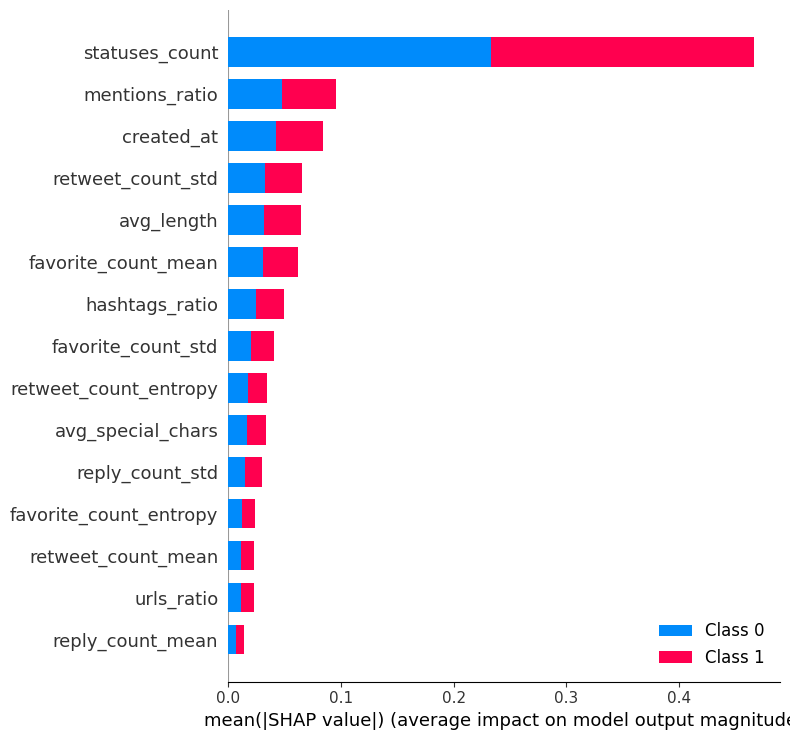

In [15]:
shap.summary_plot(shap_values, test_X[0:200], feature_names=features)

We plot the shape value of some instances (first 50) w.r.t. fixed feature, plotted against (color dimension) another one.

Plots the value of the feature on the x-axis and the SHAP value of the same feature on the y-axis. This shows how the model depends on the given feature

We can see that some feature have a kind correlation w.r.t. the shap value 

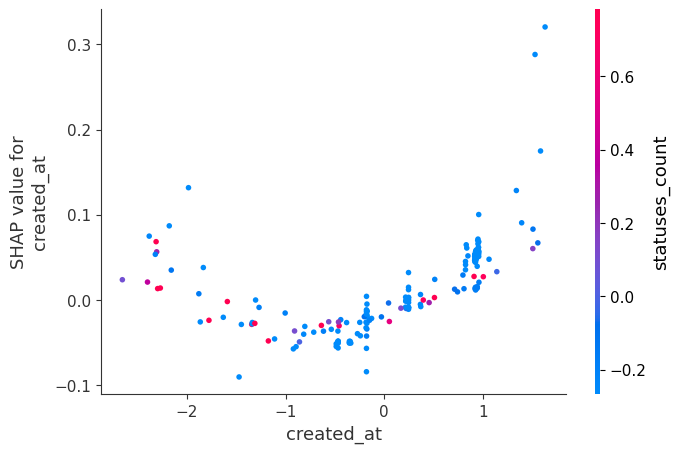

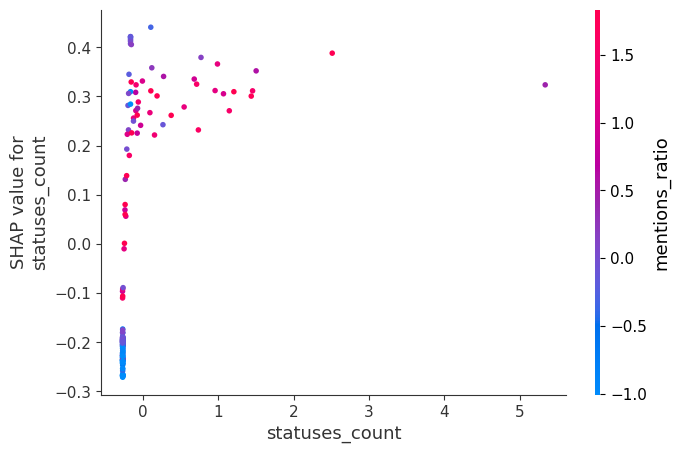

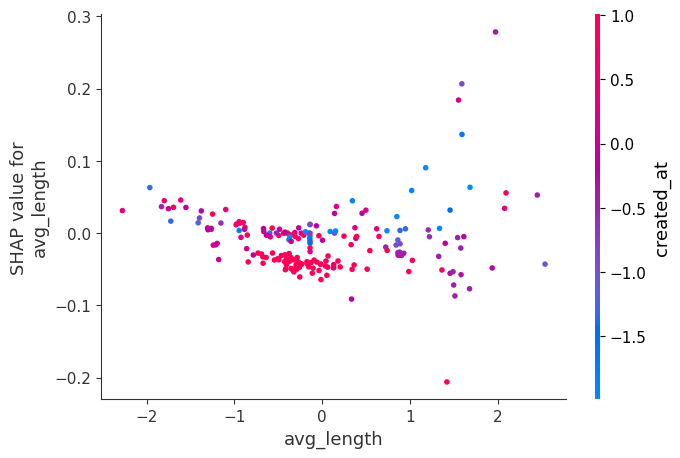

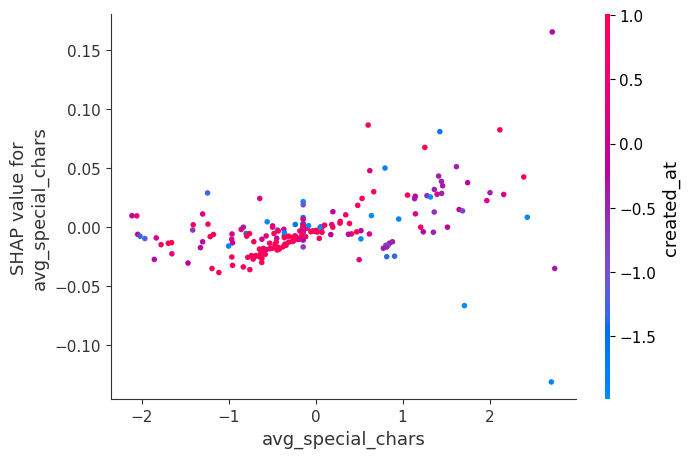

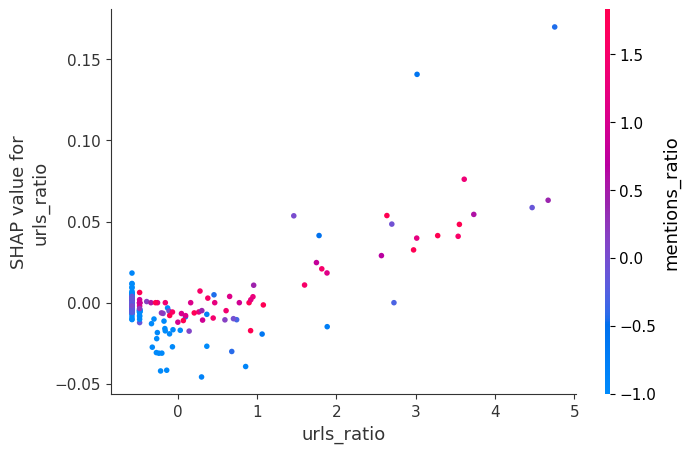

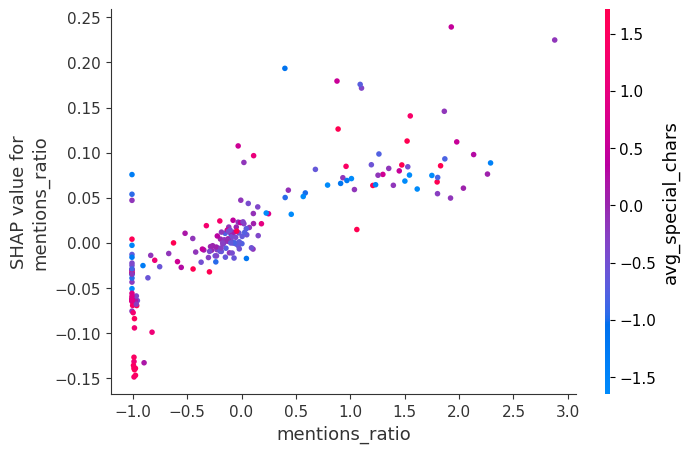

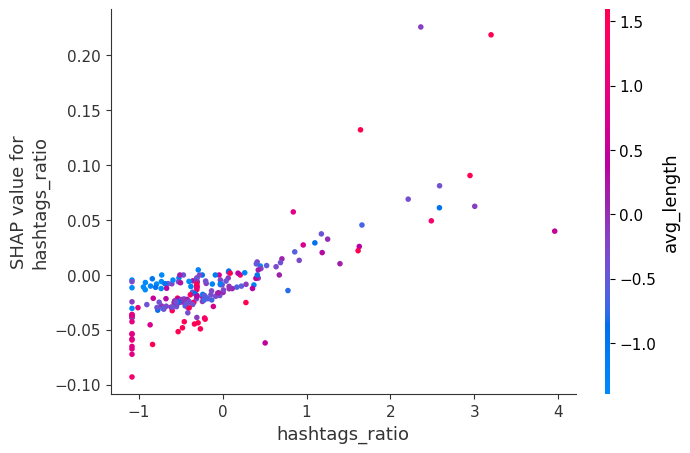

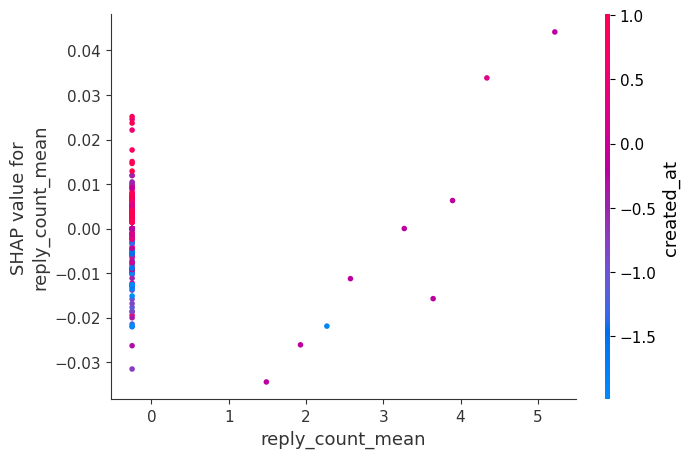

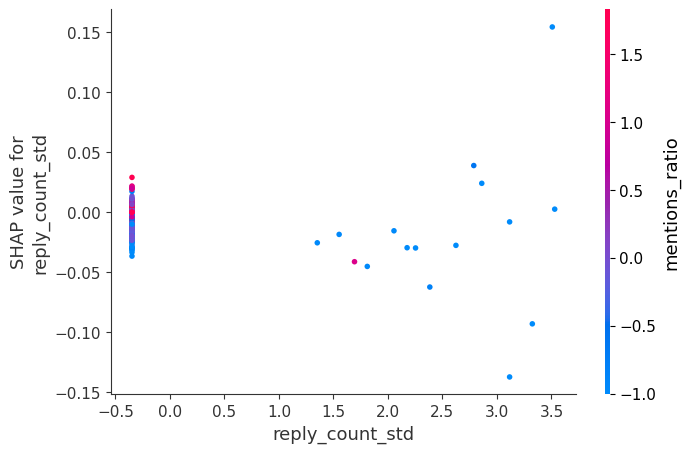

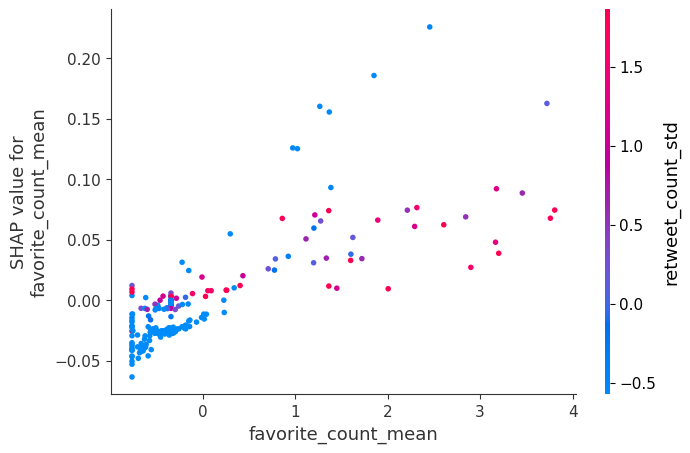

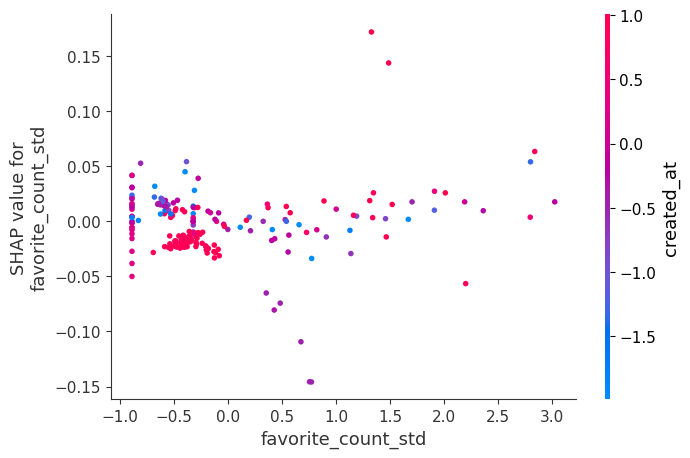

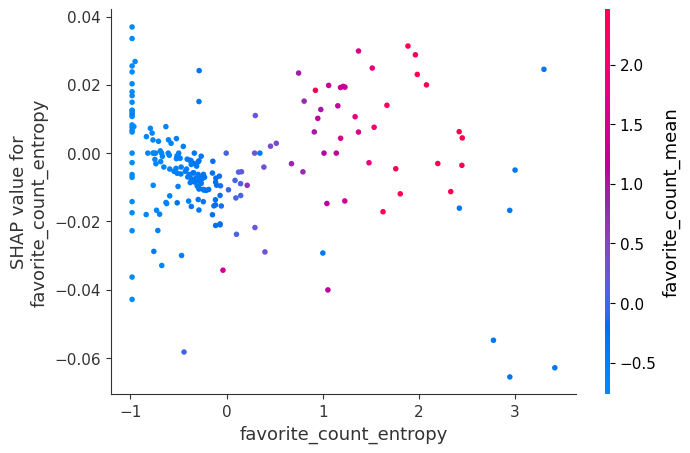

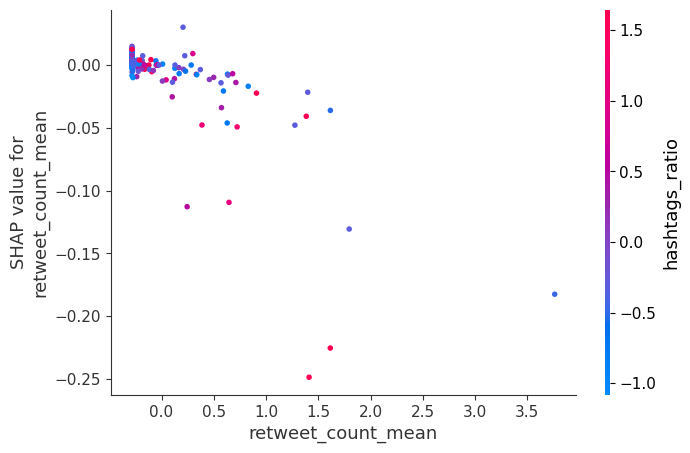

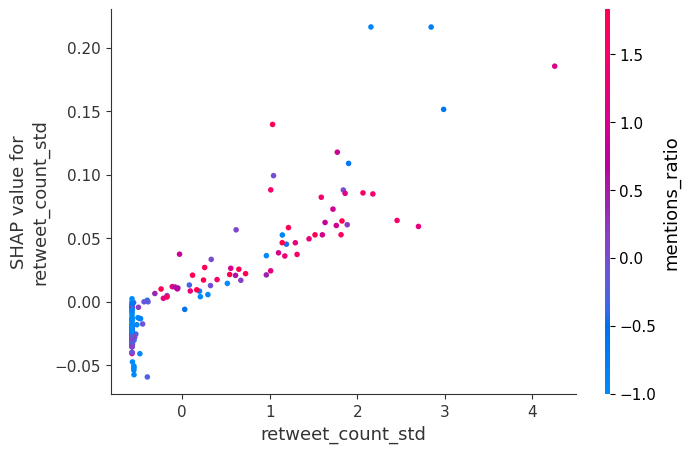

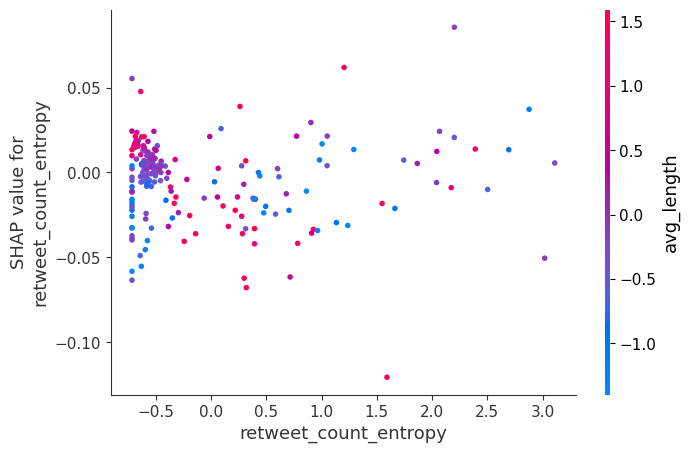

In [16]:
for feat in features:
    shap.dependence_plot(
        feat,
        shap_values[0], test_X[0:200], feature_names=features)

#### Local explanation

Explanation of the 13th instance of the test set predicted as 1

In [17]:
pd.Series(test_X[12], features)

created_at                0.215168
statuses_count           -0.266157
avg_length                0.373491
avg_special_chars         0.618178
urls_ratio               -0.579392
mentions_ratio           -1.006791
hashtags_ratio            0.183286
reply_count_mean         -0.250709
reply_count_std          -0.347567
favorite_count_mean      -0.766311
favorite_count_std       -0.890723
favorite_count_entropy   -0.983043
retweet_count_mean       -0.283026
retweet_count_std        -0.574892
retweet_count_entropy    -0.715023
dtype: float64

In [18]:
test_label.iloc[12]

1

In [19]:
nn_model.predict([test_X[12]])

array([1])

In [20]:
shap.force_plot(explainer.expected_value[1], shap_values[1][12,:], feature_names=test_set.columns.to_list())

Explanation of the second instance of the test set predicted as 0

In [21]:
pd.Series(test_X[1], features)

created_at                1.556007
statuses_count           -0.073662
avg_length               -1.247249
avg_special_chars        -1.692170
urls_ratio                1.747507
mentions_ratio            0.791255
hashtags_ratio            0.263055
reply_count_mean         -0.250709
reply_count_std          -0.347567
favorite_count_mean       0.090244
favorite_count_std        0.168709
favorite_count_entropy    0.124274
retweet_count_mean        0.498680
retweet_count_std         1.631694
retweet_count_entropy     0.981248
dtype: float64

In [22]:
nn_model.predict([test_X[1]])

array([0])

In [23]:
shap.force_plot(explainer.expected_value[0], shap_values[0][1,:], feature_names=test_set.columns.to_list())

### LIME

In [24]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(train_X, feature_names = features)

In [25]:
nn_model.predict(test_X)

array([1, 0, 1, ..., 1, 1, 0])

#### Local explanation

Explanation of the first instance of the test set predicted as 1

In [26]:
exp = lime_explainer.explain_instance(test_X[0], nn_model.predict_proba, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=True)

Explanation of the second instance of the test set predicted as 0

In [27]:
exp = lime_explainer.explain_instance(test_X[1], nn_model.predict_proba, top_labels=0)
exp.show_in_notebook(show_table=True, show_all=True)

We can see that the most important feature for LIME is **Statuses Count** as for SHAP

## Evaluation

We will print two indicator for the XAI methods.
- **Faithfulness:** evaluates the correlation between the importance assigned by the interpretability algorithm to attributes and the effect of each of the attributes on the performance of the predictive model. The metric evaluates this by incrementally removing each of the attributes deemed important by the interpretability metric, and evaluating the effect on the performance, and then calculating the correlation between the weights (importance) of the attributes and corresponding model performance. Higher is Better.
- **Monotonicity:** measures the effect of individual features on model performance by evaluating the effect on model performance of incrementally adding each attribute in order of increasing importance. As each feature is added, the performance of the model should correspondingly increase, thereby resulting in monotonically increasing model performance.

### LIME

In [28]:
exp.local_exp

{1: [(1, -0.6832950126804764),
  (0, -0.10075100337922546),
  (8, 0.08673194316019309),
  (7, 0.07185567140004194),
  (5, -0.06894154504657005),
  (12, 0.036493334478454986),
  (13, -0.031573500976075246),
  (4, -0.02292839908560322),
  (6, 0.018458811880140178),
  (2, 0.01562947014440981)]}

In [29]:
predicted_class = nn_model.predict([test_X[0]])[0]

le = exp.local_exp[predicted_class]

m = exp.as_map()

x = test_X[0]
coefs = np.zeros(x.shape[0])

for v in le:
    coefs[v[0]] = v[1]


base = np.zeros(x.shape[0])


print("Faithfulness: ", faithfulness_metric(nn_model, x, coefs, base))
print("Monotonicity: ", monotonicity_metric(nn_model, x, coefs, base))

Faithfulness:  -0.8835133389474136
Monotonicity:  False


In [30]:
ncases = 100
fait = np.zeros(ncases)
monotons = []
for i in tqdm(range(ncases)):
    predicted_class = nn_model.predict(test_X[i].reshape(1,-1))[0]
    exp = lime_explainer.explain_instance(test_X[i], nn_model.predict_proba, top_labels=1)
    le = exp.local_exp[predicted_class]
    m = exp.as_map()
    
    x = test_set.values[i]
    coefs = np.zeros(x.shape[0])
    
    for v in le:
        coefs[v[0]] = v[1]
    fait[i] = faithfulness_metric(nn_model, test_X[i], coefs, base)
    
    monotons.append(monotonicity_metric(nn_model, test_X[i], coefs, base))
    
fait[np.isnan(fait)] = 0

 17%|████████████████████████████▏                                                                                                                                         | 17/100 [00:02<00:10,  7.65it/s]invalid value encountered in divide
invalid value encountered in divide
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 68/100 [00:07<00:03,  9.71it/s]invalid value encountered in divide
invalid value encountered in divide
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 78/100 [00:08<00:01, 11.67it/s]invalid value encountered in divide
invalid value encountered in divide
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 

In [31]:
print("Faithfulness metric mean: ",np.mean(fait))
print("Faithfulness metric std. dev.:", np.std(fait))
print(f"Ratio of monotonicity : {np.sum(monotons)}/{ncases}")

Faithfulness metric mean:  0.6126765004843113
Faithfulness metric std. dev.: 0.3918726637004424
Ratio of monotonicity : 0/100


### SHAP

In [32]:
predicted_class = nn_model.predict([test_X[0]])[0]
x = test_X[0]
coefs = np.zeros(x.shape[0])
print("Faithfulness: ", faithfulness_metric(nn_model, x, shap_values[predicted_class][0], base))
print("Monotonicity: ", monotonicity_metric(nn_model, x, shap_values[predicted_class][0], base))

Faithfulness:  0.9687630586307718
Monotonicity:  False


In [33]:
ncases = 100 # max shap values istances
fait = np.zeros(ncases)
monotons = []
for i in tqdm(range(ncases)):
    predicted_class = nn_model.predict(test_X[i].reshape(1,-1))[0]
    
    fait[i] = faithfulness_metric(nn_model, test_X[i], shap_values[predicted_class][i], base)
    
    monotons.append(monotonicity_metric(nn_model, test_X[i], shap_values[predicted_class][i], base))

fait[np.isnan(fait)] = 0

 14%|███████████████████████                                                                                                                                              | 14/100 [00:00<00:00, 135.57it/s]invalid value encountered in divide
invalid value encountered in divide
 34%|████████████████████████████████████████████████████████                                                                                                             | 34/100 [00:00<00:00, 172.94it/s]invalid value encountered in divide
invalid value encountered in divide
 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 70/100 [00:00<00:00, 257.02it/s]invalid value encountered in divide
invalid value encountered in divide
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1

In [34]:
print("Faithfulness metric mean: ",np.mean(fait))
print("Faithfulness metric std. dev.:", np.std(fait))
print(f"Ratio of monotonicity : {np.sum(monotons)}/{ncases}")

Faithfulness metric mean:  0.7252131552463665
Faithfulness metric std. dev.: 0.37153523002560324
Ratio of monotonicity : 0/100
